In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import matplotlib.pyplot as plt
import shutil
from torch.autograd import Variable

# Preprocess

Extend each sticker to 512 x 512 x 3

Seperate into training data and validating data


In [2]:
raw_root = "raw data"

data_set = torchvision.datasets.ImageFolder(raw_root)
count = np.zeros((len(data_set.classes)), np.int)
for i in range(len(data_set)):
    count[data_set.classes.index(data_set.imgs[i][0].split('/')[1])] += 1

train_root = "train data"
valid_root = "valid data"

if os.path.isdir(train_root):
    shutil.rmtree(train_root)

os.mkdir(train_root)

if os.path.isdir(valid_root):
    shutil.rmtree(valid_root)

os.mkdir(valid_root)


# decide which datum be valid data, each class has same rate of valid data
valid_rate = 0.25
valid_lots = []
for i in range(len(data_set.classes)):
    lots = ((np.arange(count[i])/count[i]) < valid_rate)
    np.random.shuffle(lots)
    valid_lots += lots.tolist()

idx_lot = 0
for class_name in os.listdir(raw_root):
    class_path = os.path.join(raw_root, class_name)
    train_class_path = os.path.join(train_root, class_name)
    valid_class_path = os.path.join(valid_root, class_name)
    os.mkdir(train_class_path)
    os.mkdir(valid_class_path)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if file_name.endswith(".png"):
                file_path = os.path.join(class_path, file_name)
                train_file_path = os.path.join(train_class_path, file_name)
                valid_file_path = os.path.join(valid_class_path, file_name) 
                img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
                x, y, _ = img.shape
                new_img = np.zeros((512, 512, 4), np.uint8)
                new_img[256-int(x/2): 256+int((x+1)/2), 256-int(y/2): 256+int((y+1)/2), :] = img
                for c in range(3):
                    new_img[:,:,c][new_img[:,:,3]==0] = 255
                
                if valid_lots[idx_lot]:
                    cv2.imwrite(valid_file_path, new_img)
                else:
                    cv2.imwrite(train_file_path, new_img)
                
                idx_lot += 1

shutil.rmtree(os.path.join(train_root, ".DS_store"))
shutil.rmtree(os.path.join(valid_root, ".DS_store"))

# Loading data

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                           torchvision.transforms.RandomRotation(90),
                                           torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.5, 0.5, 0.5],
                                                                             [0.5, 0.5, 0.5]
                                                                            )
                                           ]
                                          )

# count images and weight for unbalance data
train_data = torchvision.datasets.ImageFolder(train_root)
count = np.zeros((len(train_data.classes)), np.int)
for i in range(len(train_data)):
    count[train_data.classes.index(train_data.imgs[i][0].split('/')[1])] += 1

weight = np.zeros((len(train_data)))
for i in range(len(train_data)):
    weight[i] = count[train_data.classes.index(train_data.imgs[i][0].split('/')[1])]

weight = 1/weight.astype(np.float64)
weight = weight/weight.sum()
sampler = utils.sampler.WeightedRandomSampler(weight, len(train_data))

train_data = torchvision.datasets.ImageFolder(train_root, transform=transform)
valid_data = torchvision.datasets.ImageFolder(valid_root, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, num_workers=2, sampler=sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True, num_workers=2)

# Construct Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 10, 9) # (512 - 8)/2 = 252
        self.conv2 = nn.Conv2d(10, 20, 5) # (252 - 4)/2 = 124
        self.conv3 = nn.Conv2d(20, 40, 5) # (124 - 4)/2 = 60
        self.conv4 = nn.Conv2d(40, 80, 5) # (60 - 4)/2 = 28
        self.fc1 = nn.Linear(80 * 28 * 28, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 40)
        self.fc4 = nn.Linear(40, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 80 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)

In [5]:
for epoch in range(50):
    print("epoch {}".format(epoch+1))
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = Variable(inputs)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_acc += (outputs.argmax(dim=1) == labels).type(torch.DoubleTensor).mean()
    
    print('train loss/acc: {0} / {1:.3f}'.format(running_loss/len(train_loader), running_acc/len(train_loader)))
    
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs = Variable(inputs)
        labels = Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.data
        running_acc += (outputs.argmax(dim=1) == labels).type(torch.DoubleTensor).mean()
    
    print('valid loss/acc: {0} / {1:.3f}'.format(running_loss/len(valid_loader), running_acc/len(valid_loader)))

epoch 1
train loss/acc: 0.6958304047584534 / 0.514
valid loss/acc: 0.6789942383766174 / 0.653
epoch 2
train loss/acc: 0.6897933483123779 / 0.549
valid loss/acc: 0.6730590462684631 / 0.660
epoch 3
train loss/acc: 0.6862272620201111 / 0.556
valid loss/acc: 0.6704117655754089 / 0.639
epoch 4
train loss/acc: 0.6453348398208618 / 0.708
valid loss/acc: 0.6291853785514832 / 0.708
epoch 5
train loss/acc: 0.5734694004058838 / 0.701
valid loss/acc: 0.720794677734375 / 0.639
epoch 6
train loss/acc: 0.5231418013572693 / 0.736
valid loss/acc: 0.5469681024551392 / 0.694
epoch 7
train loss/acc: 0.5897414088249207 / 0.708
valid loss/acc: 0.5425930619239807 / 0.715
epoch 8
train loss/acc: 0.5201719403266907 / 0.701
valid loss/acc: 0.5495481491088867 / 0.736
epoch 9
train loss/acc: 0.49926450848579407 / 0.764
valid loss/acc: 0.4239109456539154 / 0.826
epoch 10
train loss/acc: 0.4766940474510193 / 0.750
valid loss/acc: 0.5110109448432922 / 0.729
epoch 11
train loss/acc: 0.5088546872138977 / 0.771
valid l

normal ,SD ,SD ,SD ,normal ,normal ,normal ,normal ,


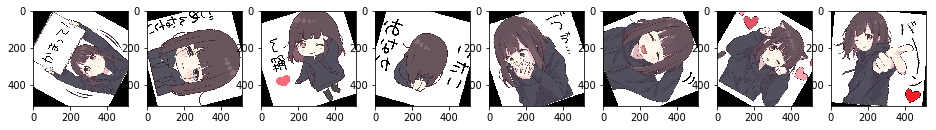

In [10]:
for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    output = net(inputs)
    inference = output.argmax(dim=1)
    for i2 in range(8):
        print(valid_data.classes[inference[i2]], end=" ,")
    
    print() #warp
    
    imgs = np.array(inputs).transpose((0,2,3,1))
    imgs = 127.5*(imgs+1)
    imgs = imgs.astype(np.uint8)
    fig=plt.figure(figsize=(16, 16))
    for i2 in range(8):
        fig.add_subplot(1, 8, i2+1)
        plt.imshow(imgs[i2])
    plt.show()
    break